## 1. Setup & Imports

In [297]:
# !pip install --upgrade --force-reinstall \
#   numpy==1.26.4 \
#   statsmodels\
#   yfinance \
#   pmdarima\
#   arch\
#   ta\
#   TA-Lib

In [298]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')
%matplotlib inline

# Data collection
import yfinance as yf

# Statistical models
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import scipy.stats as stats

# ML utilities
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

print("Environment ready")

Environment ready


## 2. Data Collection

In [299]:
# Download BTC data
ticker = "BTC-USD"
start_date = "2014-01-01"

print(f"Downloading {ticker} from {start_date}...")
btc = yf.download(ticker, start=start_date, progress=False)

# Fix multi-index columns if needed
if isinstance(btc.columns, pd.MultiIndex):
    btc.columns = btc.columns.get_level_values(0)

print(f"✓ Downloaded {len(btc)} days of data")
btc.tail()

✓ Downloaded 4101 days of data


Price,Close,High,Low,Open,Volume
Date,,,,,
2025-12-04,92141.625000,94038.242188,90976.101562,93454.257812,64538402681
2025-12-05,89387.757812,92702.640625,88152.140625,92133.648438,63256398633
2025-12-06,89272.375000,90267.460938,88951.664062,89389.359375,37994042405
2025-12-07,90405.640625,91740.843750,87799.562500,89277.812500,47394898960
2025-12-08,91906.312500,92216.906250,90006.031250,90426.945312,56629530624


## 3. Data Preparation

In [300]:
# Clean data
btc.index = pd.to_datetime(btc.index)
btc = btc[~btc.index.duplicated(keep='first')]
btc.dropna(inplace=True)
btc.sort_index(inplace=True)

# Calculate log returns (stationary series for modeling)
btc['LogReturn'] = np.log(btc['Close'] / btc['Close'].shift(1))
btc.dropna(inplace=True)

print(f"✓ Data prepared: {len(btc)} rows")
print(f"✓ Date range: {btc.index[0].date()} to {btc.index[-1].date()}")

✓ Data prepared: 4100 rows
✓ Date range: 2014-09-18 to 2025-12-08


## 4. Stationarity Check

Dataset Statistics:
Price          Close        Volume    LogReturn
count    4100.000000  4.100000e+03  4100.000000
mean    26509.677204  2.151978e+10     0.001293
std     31401.996688  2.285640e+10     0.035498
min       178.102997  5.914570e+06    -0.464730
25%      2658.692383  1.212425e+09    -0.012587
50%     10667.725586  1.699237e+10     0.001225
75%     41757.313477  3.294587e+10     0.016084
max    124752.531250  3.509679e+11     0.225119

 EDA complete - Volatility clustering visible, justifying GARCH approach


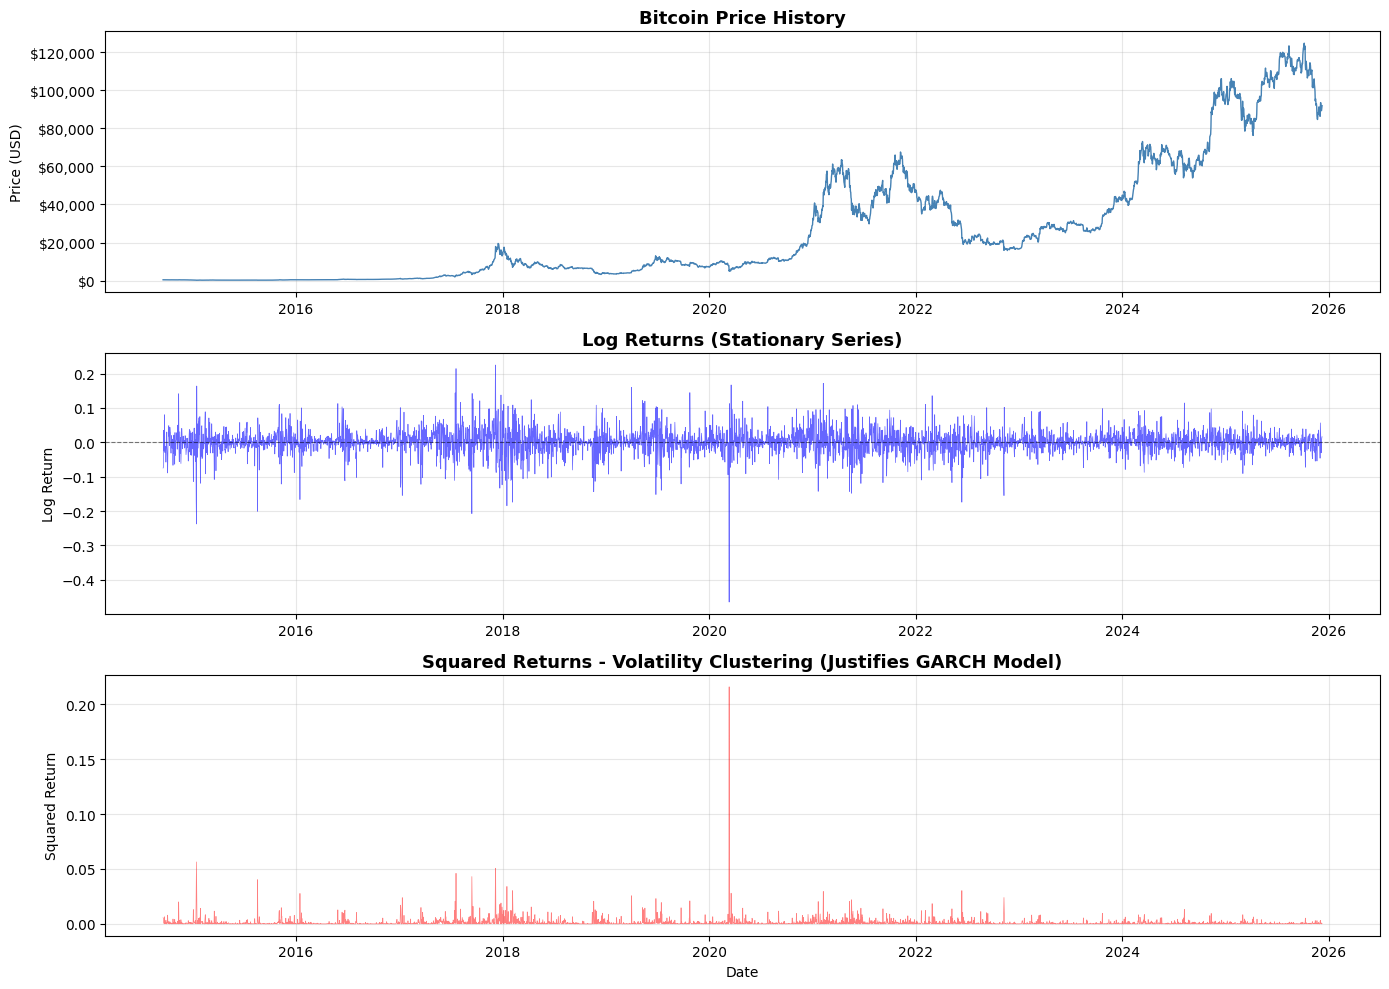

In [301]:
# Quick overview of the data
print("Dataset Statistics:")
print(btc[['Close', 'Volume', 'LogReturn']].describe())

# Visualize price history and returns
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Price over time
axes[0].plot(btc.index, btc['Close'], color='steelblue', linewidth=1)
axes[0].set_title('Bitcoin Price History', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Price (USD)')
axes[0].grid(True, alpha=0.3)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Plot 2: Log Returns (stationary series)
axes[1].plot(btc.index, btc['LogReturn'], color='blue', alpha=0.6, linewidth=0.5)
axes[1].axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1].set_title('Log Returns (Stationary Series)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Log Return')
axes[1].grid(True, alpha=0.3)

# Plot 3: Volatility Clustering (justifies GARCH)
axes[2].plot(btc.index, btc['LogReturn']**2, color='red', alpha=0.5, linewidth=0.5)
axes[2].set_title('Squared Returns - Volatility Clustering (Justifies GARCH Model)', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Squared Return')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()

print("\n EDA complete - Volatility clustering visible, justifying GARCH approach")

### 3.1 Exploratory Data Analysis

In [302]:
# ADF test for stationarity
def adf_test(series, name):
    result = adfuller(series)
    print(f"\n{name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  Status: {'STATIONARY ✓' if result[1] <= 0.05 else 'NON-STATIONARY ✗'}")

adf_test(btc['Close'], "Price")
adf_test(btc['LogReturn'], "Log Returns")


Price:
  ADF Statistic: -0.7055
  p-value: 0.8453
  Status: NON-STATIONARY ✗

Log Returns:
  ADF Statistic: -19.4614
  p-value: 0.0000
  Status: STATIONARY ✓


## 5. Feature Engineering

In [303]:
# RSI (Momentum indicator)
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Create base features
btc['RSI'] = calculate_rsi(btc['Close'])
btc['Rolling_Vol'] = btc['LogReturn'].rolling(window=30).std()
btc['SMA_20'] = btc['Close'].rolling(window=20).mean()
btc['Trend_Dist'] = (btc['Close'] / btc['SMA_20']) - 1

# Momentum features (rate of price change over N days)
btc['Momentum_3'] = btc['Close'].pct_change(3)    # 3-day momentum
btc['Momentum_7'] = btc['Close'].pct_change(7)    # 7-day momentum

# Lag features (past returns for memory)
btc['Lag_1'] = btc['LogReturn'].shift(1)          # Yesterday's return
btc['Lag_2'] = btc['LogReturn'].shift(2)          # 2 days ago return

# Drop NaN rows
btc.dropna(inplace=True)

print(f" Features created: {len(btc)} rows after cleanup")
print(f" Total features: 7 (RSI, Rolling_Vol, Trend_Dist, Momentum_3, Momentum_7, Lag_1, Lag_2)")

 Features created: 4071 rows after cleanup
 Total features: 7 (RSI, Rolling_Vol, Trend_Dist, Momentum_3, Momentum_7, Lag_1, Lag_2)


## 6. Feature Correlation Analysis

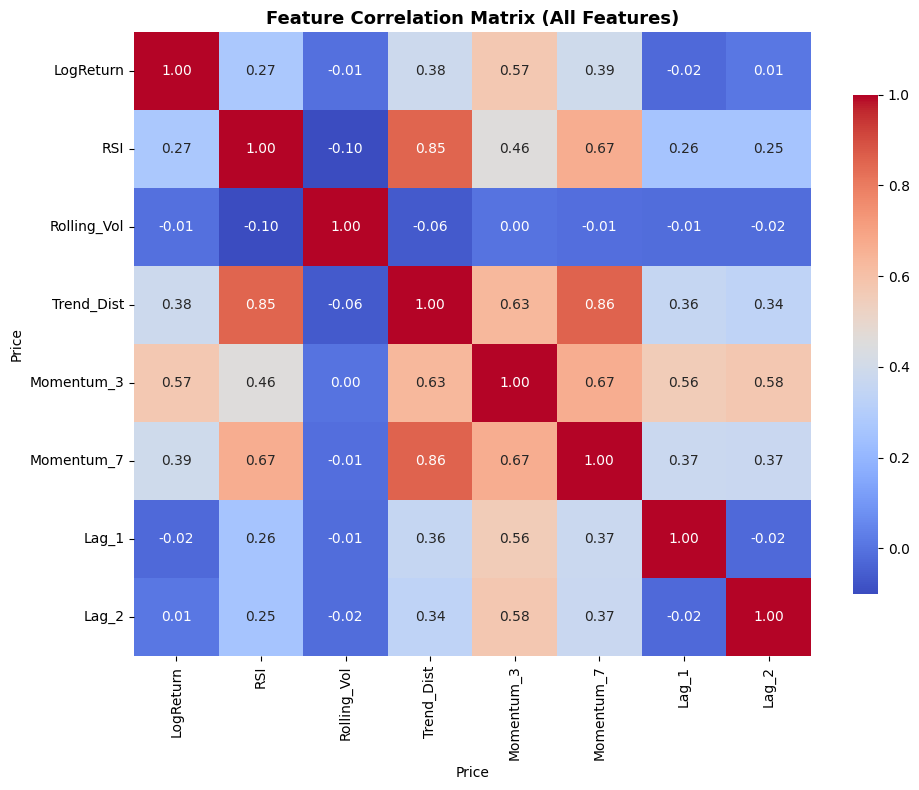

In [304]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_features = ['LogReturn', 'RSI', 'Rolling_Vol', 'Trend_Dist', 'Momentum_3', 'Momentum_7', 'Lag_1', 'Lag_2']
sns.heatmap(btc[corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix (All Features)', fontsize=13, fontweight='bold')
plt.tight_layout()

## 7. Train-Test Split & Scaling

In [305]:
# Define target and features
y = btc['LogReturn']

# CRITICAL FIX: Shift features by 1 day to avoid look-ahead bias
# We use YESTERDAY's features to predict TODAY's return
exog_features = ['RSI', 'Rolling_Vol', 'Trend_Dist', 'Momentum_3', 'Momentum_7', 'Lag_1', 'Lag_2']
X = btc[exog_features].shift(1)  # Shift features by 1 day

# Drop NaN rows created by shifting
btc_aligned = btc.copy()
btc_aligned[exog_features] = X
btc_aligned.dropna(inplace=True)

# Update y and X after alignment
y = btc_aligned['LogReturn']
X = btc_aligned[exog_features]

# Time-series split (80/20)
train_size = int(len(btc_aligned) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train_raw, X_test_raw = X.iloc[:train_size], X.iloc[train_size:]

# Scale features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), 
                       index=X_train_raw.index, columns=X_train_raw.columns)
X_test = pd.DataFrame(scaler.transform(X_test_raw), 
                      index=X_test_raw.index, columns=X_test_raw.columns)

print(f"✓ Training: {len(y_train)} days | Test: {len(y_test)} days")
print(f"✓ Features used: {len(exog_features)} (RSI, Rolling_Vol, Trend_Dist, Momentum_3, Momentum_7, Lag_1, Lag_2)")

✓ Training: 3256 days | Test: 814 days
✓ Features used: 7 (RSI, Rolling_Vol, Trend_Dist, Momentum_3, Momentum_7, Lag_1, Lag_2)


## 8. ARIMAX Model Training

In [306]:
# Fit ARIMAX(1,0,1) model
print("Training ARIMAX(1,0,1) model...")
model = ARIMA(y_train, exog=X_train, order=(1,0,1))
model_fit = model.fit()
print("✓ ARIMAX model trained\n")

print(model_fit.summary().tables[1])

Training ARIMAX(1,0,1) model...
✓ ARIMAX model trained

                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0013      0.001      2.053      0.040    5.88e-05       0.003
RSI             0.0041      0.001      3.453      0.001       0.002       0.006
Rolling_Vol     0.0004      0.001      0.683      0.494      -0.001       0.001
Trend_Dist     -0.0033      0.001     -2.328      0.020      -0.006      -0.001
Momentum_3      0.0117      0.004      2.790      0.005       0.003       0.020
Momentum_7      0.0007      0.001      0.695      0.487      -0.001       0.003
Lag_1          -0.0086      0.004     -2.246      0.025      -0.016      -0.001
Lag_2          -0.0059      0.003     -2.272      0.023      -0.011      -0.001
ar.L1          -0.2848      0.309     -0.921      0.357      -0.891       0.322
ma.L1           0.0815      0.314      0.260      0.795      -0.

## 9. GARCH Volatility Model

In [307]:
# Fit GARCH(1,1) on ARIMAX residuals
residuals = model_fit.resid

print("Training GARCH(1,1) model on residuals...")
garch_model = arch_model(residuals * 100, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

print("\n✓ GARCH model trained")
print(garch_fit.summary().tables[1])

Training GARCH(1,1) model on residuals...

✓ GARCH model trained
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0506  5.545e-02      0.913      0.361 [-5.804e-02,  0.159]


## 10. Out-of-Sample Testing

In [308]:
# Generate forecasts
print("Generating out-of-sample forecasts...")

# Mean forecast from ARIMAX
mu_test = model_fit.forecast(steps=len(y_test), exog=X_test)

# Volatility forecast from GARCH
train_vol = garch_fit.conditional_volatility / 100
vol_test = pd.Series(train_vol.mean(), index=y_test.index)  # Simplified: use average training vol

# Align lengths
min_len = min(len(mu_test), len(vol_test), len(y_test))
mu_test = mu_test.iloc[:min_len]
vol_test = vol_test.iloc[:min_len]
y_test_aligned = y_test.iloc[:min_len]

# Calculate probability of up move
z_scores = (0 - mu_test) / vol_test
probs_up = 1 - stats.norm.cdf(z_scores)

# Create results dataframe
results = pd.DataFrame({
    'Actual_Return': y_test_aligned,
    'Pred_Mean': mu_test,
    'Pred_Vol': vol_test,
    'Prob_Up': probs_up
})

results['Signal'] = (results['Prob_Up'] > 0.50).astype(int)
results['Actual_Dir'] = (results['Actual_Return'] > 0).astype(int)

# Calculate accuracy
accuracy = (results['Signal'] == results['Actual_Dir']).mean()
print(f"\n✓ Directional Accuracy: {accuracy:.2%}")

# Classification report
print("\nClassification Report:")
print(classification_report(results['Actual_Dir'], results['Signal'], 
                          target_names=['DOWN', 'UP']))

Generating out-of-sample forecasts...

✓ Directional Accuracy: 48.89%

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.47      0.39      0.43       395
          UP       0.50      0.58      0.54       419

    accuracy                           0.49       814
   macro avg       0.49      0.49      0.48       814
weighted avg       0.49      0.49      0.48       814



## 11. Performance Visualization

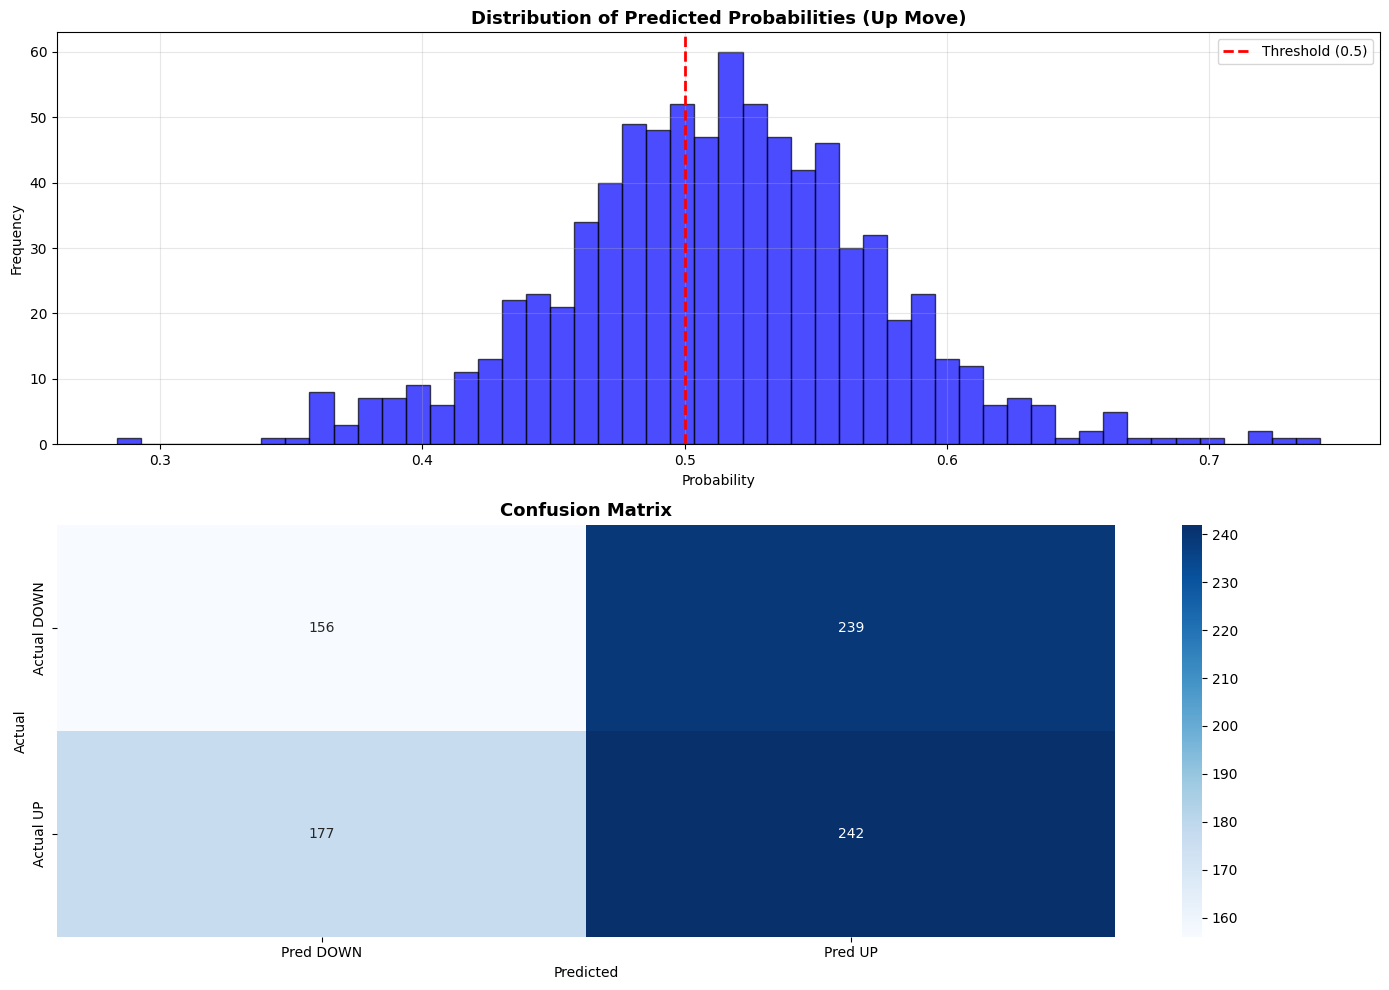

In [309]:
# Plot results
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Probability distribution
axes[0].hist(results['Prob_Up'], bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[0].set_title('Distribution of Predicted Probabilities (Up Move)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Probability')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion matrix
cm = confusion_matrix(results['Actual_Dir'], results['Signal'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
           xticklabels=['Pred DOWN', 'Pred UP'],
           yticklabels=['Actual DOWN', 'Actual UP'])
axes[1].set_title('Confusion Matrix', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()

## 12. Tomorrow's Prediction

In [310]:
# Extract latest features
today = pd.Timestamp.now().date()
tomorrow = today + timedelta(days=1)

last_price = btc['Close'].iloc[-1]
latest_rsi = btc['RSI'].iloc[-1]
latest_vol = btc['Rolling_Vol'].iloc[-1]
latest_trend = btc['Trend_Dist'].iloc[-1]
latest_momentum_3 = btc['Momentum_3'].iloc[-1]
latest_momentum_7 = btc['Momentum_7'].iloc[-1]
latest_lag_1 = btc['Lag_1'].iloc[-1]
latest_lag_2 = btc['Lag_2'].iloc[-1]

print("="*70)
print(f"BITCOIN DIRECTIONAL FORECAST - {tomorrow}")
print("="*70)
print(f"\nCurrent Price: ${last_price:,.2f}")
print(f"\nFeatures:")
print(f"  RSI: {latest_rsi:.2f}")
print(f"  Volatility: {latest_vol:.6f}")
print(f"  Trend Distance: {latest_trend*100:.2f}%")
print(f"  3-Day Momentum: {latest_momentum_3*100:.2f}%")
print(f"  7-Day Momentum: {latest_momentum_7*100:.2f}%")
print(f"  Lag 1 (Yesterday): {latest_lag_1:.6f}")
print(f"  Lag 2 (2 Days Ago): {latest_lag_2:.6f}")

# Scale features (all 7 features)
features_tomorrow = pd.DataFrame({
    'RSI': [latest_rsi],
    'Rolling_Vol': [latest_vol],
    'Trend_Dist': [latest_trend],
    'Momentum_3': [latest_momentum_3],
    'Momentum_7': [latest_momentum_7],
    'Lag_1': [latest_lag_1],
    'Lag_2': [latest_lag_2]
})
features_scaled = pd.DataFrame(scaler.transform(features_tomorrow), columns=exog_features)

# Generate prediction
forecast_mean = model_fit.forecast(steps=1, exog=features_scaled).values[0]
forecast_vol = train_vol.mean()  # Use average training volatility

# Calculate probability
prob_up = 1 - stats.norm.cdf((0 - forecast_mean) / forecast_vol)
prob_down = 1 - prob_up

# Price prediction
expected_price = last_price * np.exp(forecast_mean)
price_lower = last_price * np.exp(forecast_mean - forecast_vol)
price_upper = last_price * np.exp(forecast_mean + forecast_vol)

print(f"\n{'='*70}")
print("PREDICTION")
print(f"{'='*70}")
print(f"\nProbability UP: {prob_up:.2%}")
print(f"Probability DOWN: {prob_down:.2%}")
print(f"\nDirection: {'📈 UP' if prob_up > 0.5 else '📉 DOWN'}")
print(f"Confidence: {max(prob_up, prob_down):.2%}")
print(f"\nExpected Price: ${expected_price:,.2f}")
print(f"95% Range: ${price_lower:,.2f} - ${price_upper:,.2f}")

# 5. Save prediction to CSV (Syntax fixed)
prediction_df = pd.DataFrame([{
    'Date': str(tomorrow),
    'Current_Price': last_price,
# Save prediction
    'Probability_Up': prob_up,
    'Direction': 'UP' if prob_up > 0.5 else 'DOWN', 
    'Price_Lower': price_lower,
    'Price_Upper': price_upper
}])

prediction_df.to_csv('btc_tomorrow_prediction.csv', index=False)
print(f"\n✓ Prediction saved to 'btc_tomorrow_prediction.csv'")

BITCOIN DIRECTIONAL FORECAST - 2025-12-09

Current Price: $91,906.31

Features:
  RSI: 57.60
  Volatility: 0.025632
  Trend Distance: 2.77%
  3-Day Momentum: 2.82%
  7-Day Momentum: 6.47%
  Lag 1 (Yesterday): 0.012615
  Lag 2 (2 Days Ago): -0.001292

PREDICTION

Probability UP: 54.98%
Probability DOWN: 45.02%

Direction: 📈 UP
Confidence: 54.98%

Expected Price: $92,326.90
95% Range: $89,021.22 - $95,755.33

✓ Prediction saved to 'btc_tomorrow_prediction.csv'


## 13. Visualization for Dashboard

✓ Dashboard chart saved as 'btc_forecast_dashboard.png'


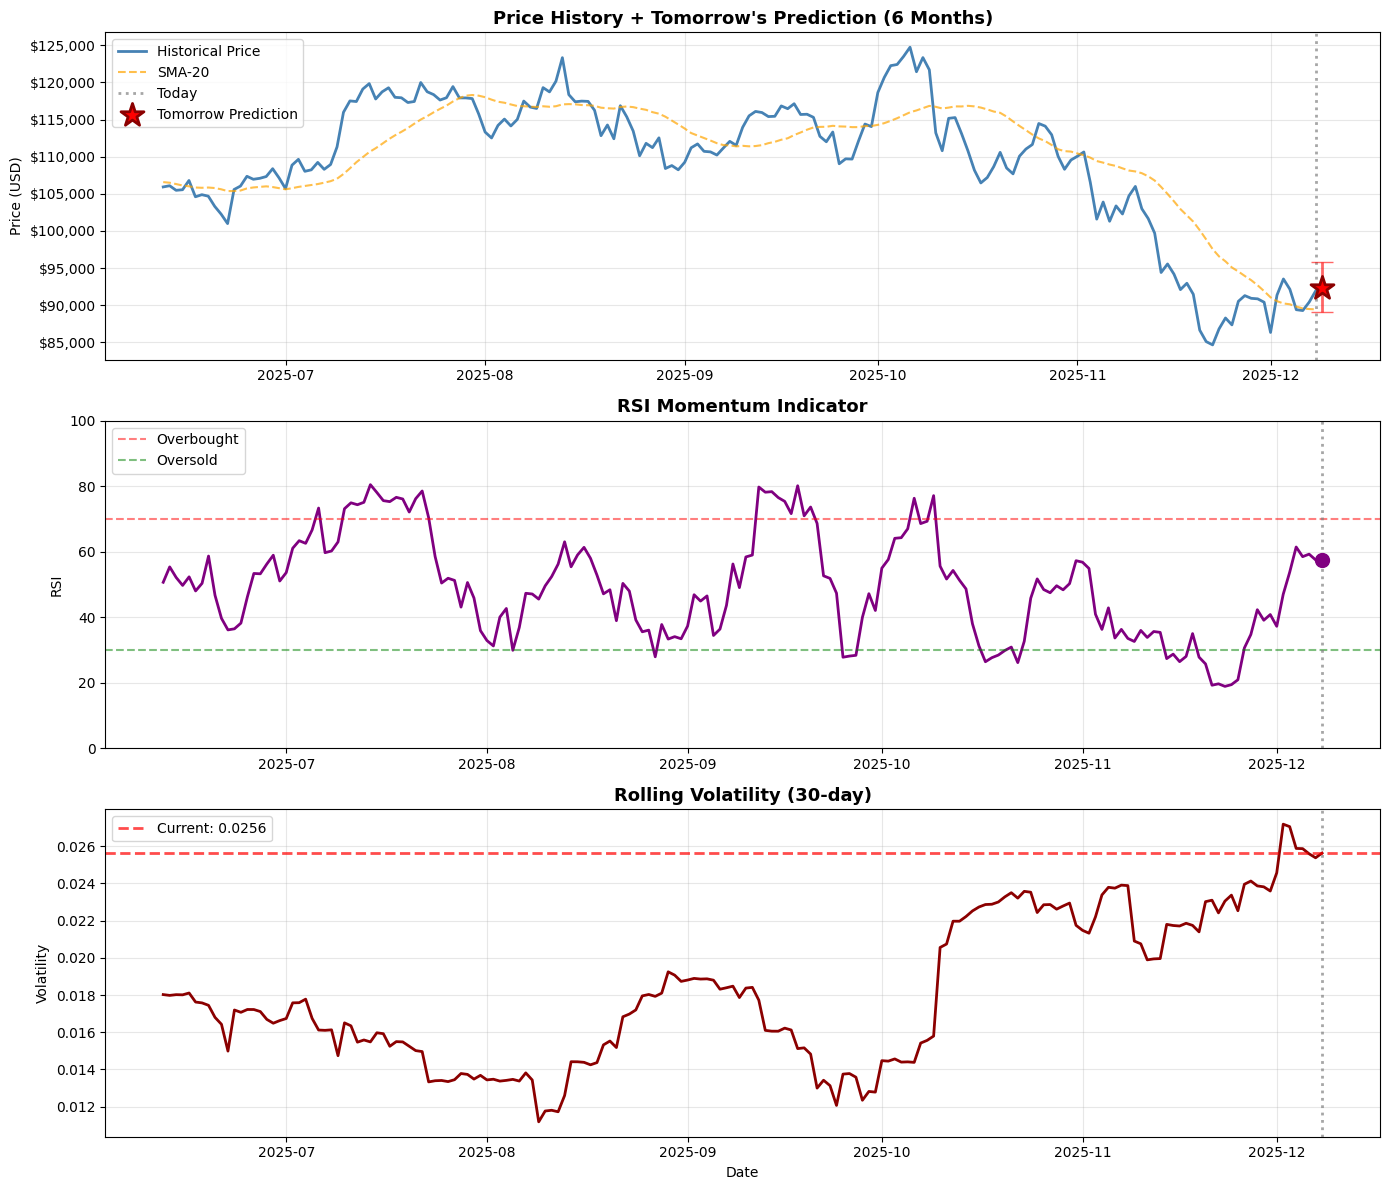

In [311]:
# Create dashboard-ready visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Last 6 months data
last_6m = pd.Timestamp.now() - pd.Timedelta(days=180)
plot_data = btc[btc.index >= last_6m].copy()
today_ts = pd.Timestamp(today)
tomorrow_ts = pd.Timestamp(tomorrow)

# Plot 1: Price + Prediction
axes[0].plot(plot_data.index, plot_data['Close'], label='Historical Price', 
            color='steelblue', linewidth=2)
axes[0].plot(plot_data.index, plot_data['SMA_20'], label='SMA-20', 
            color='orange', linewidth=1.5, linestyle='--', alpha=0.7)
axes[0].axvline(today_ts, color='gray', linestyle=':', linewidth=2, alpha=0.7, label='Today')
axes[0].scatter([tomorrow_ts], [expected_price], color='red', s=300, marker='*', 
               zorder=5, label='Tomorrow Prediction', edgecolor='darkred', linewidths=2)
axes[0].errorbar([tomorrow_ts], [expected_price], 
                yerr=[[expected_price-price_lower], [price_upper-expected_price]],
                fmt='none', ecolor='red', elinewidth=2, capsize=8, alpha=0.6)
axes[0].set_title('Price History + Tomorrow\'s Prediction (6 Months)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Price (USD)')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Plot 2: RSI
axes[1].plot(plot_data.index, plot_data['RSI'], color='purple', linewidth=2)
axes[1].axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought')
axes[1].axhline(30, color='green', linestyle='--', alpha=0.5, label='Oversold')
axes[1].axvline(today_ts, color='gray', linestyle=':', linewidth=2, alpha=0.7)
axes[1].scatter([today_ts], [latest_rsi], color='purple', s=100, marker='o', zorder=5)
axes[1].set_title('RSI Momentum Indicator', fontsize=13, fontweight='bold')
axes[1].set_ylabel('RSI')
axes[1].set_ylim([0, 100])
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

# Plot 3: Volatility
axes[2].plot(plot_data.index, plot_data['Rolling_Vol'], color='darkred', linewidth=2)
axes[2].axhline(latest_vol, color='red', linestyle='--', alpha=0.7, linewidth=2,
               label=f'Current: {latest_vol:.4f}')
axes[2].axvline(today_ts, color='gray', linestyle=':', linewidth=2, alpha=0.7)
axes[2].set_title('Rolling Volatility (30-day)', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Volatility')
axes[2].set_xlabel('Date')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('btc_forecast_dashboard.png', dpi=300, bbox_inches='tight')
print("✓ Dashboard chart saved as 'btc_forecast_dashboard.png'")

---

## Summary

This notebook implements a directional forecasting system for Bitcoin using:
- **ARIMAX(1,0,1)**: Captures mean return with 7 exogenous features:
  - Technical: RSI, Rolling Volatility, Trend Distance
  - Momentum: 3-day and 7-day price momentum
  - Memory: Lag-1 and Lag-2 past returns
- **GARCH(1,1)**: Models conditional volatility from residuals

- **Probabilistic Output**: Provides probability of up/down movement with confidence intervals**Next Steps**: Use this output for Streamlit dashboard development with real-time predictions and interactive visualizations.



**Feature Engineering Highlights**:- Standardized scaling for optimal ARIMAX performance

- All features shifted by 1 day to avoid look-ahead bias- Combines technical indicators, momentum signals, and autoregressive memory